# CFF Fitting using Gepard

## Dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g
print(g.__file__)
import sys

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/__init__.py


In [3]:
import gepard as g
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts, th_KM15, th_KM10b
import matplotlib.pyplot as plt
from gepard.fits import th_KM15
th15 = th_KM15
import torch
import shelve, logging, sys, copy
#from gepard.fits import th_KM12
th12 = th_KM15

In [4]:
#utils.listdata([101,102], data)
fitpoints =  g.dset[8] + g.dset[101] + g.dset[102] #+g.dset[97] + g.dset[99] +
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156


In [5]:
#utils.listdata([8], data)
data = g.dset[8]
BSA = data.df()   # ALU(90 deg) by CLAS 2007
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [6]:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '-t')

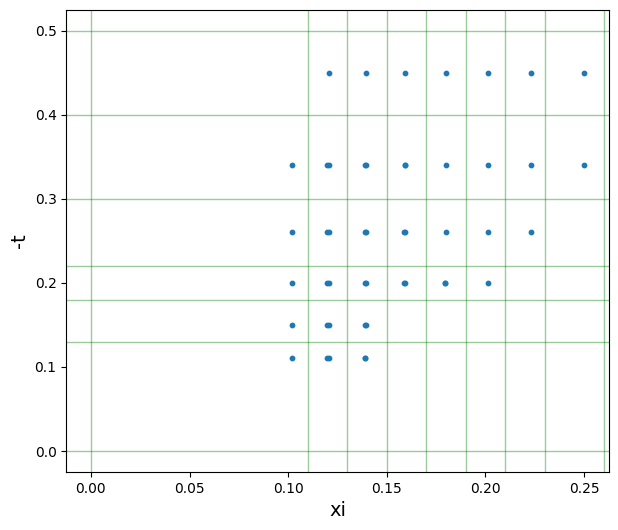

In [7]:
#plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSD.xi, BSD.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel('xi', fontsize=14)
ax.set_ylabel('-t', fontsize=14)
#fig.savefig('bins.pdf')

Text(0, 0.5, '-t')

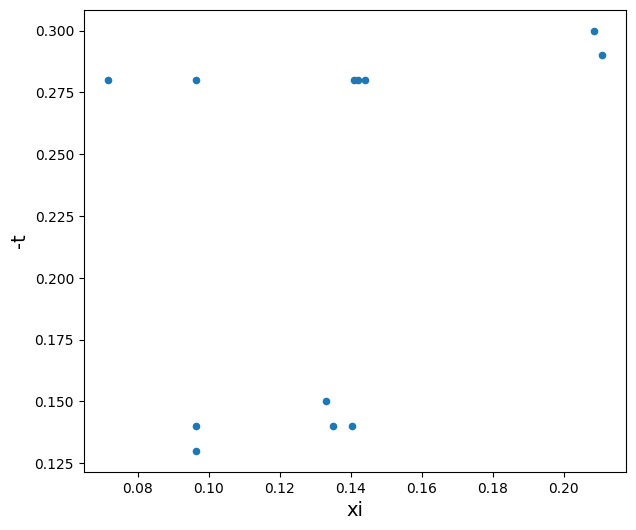

In [8]:
fig, ax = plt.subplots(figsize=[7,6])
plt.scatter(BSA.xi, BSA.tm, s=20)
ax.set_xlabel('xi', fontsize=14)
ax.set_ylabel('-t', fontsize=14)

## Fit with NN

In [9]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = torch.nn.Sequential(
                torch.nn.Linear(2, 12),
                torch.nn.ReLU(),
                torch.nn.Linear(12, 17),
                torch.nn.ReLU(),
                torch.nn.Linear(17, 12),
                torch.nn.ReLU(),
                torch.nn.Linear(12, len(self.output_layer))
            )
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer

In [10]:
g.describe_data(fitpoints)
th = NNTest(output_layer=['ImH', 'ReH'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#
print(th.useDR)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156
None


In [11]:
f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch  10: train error = 1.4677 test error = 1.7309 -
Epoch  20: train error = 1.0817 test error = 1.6128 -
Epoch  30: train error = 1.0152 test error = 1.8900 +
Epoch  40: train error = 0.9618 test error = 1.9222 +
Epoch  50: train error = 0.9248 test error = 1.8550 +
Epoch  60: train error = 0.8854 test error = 1.8820 +test_err = 1.6128279026226675 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.6128279026226675

Epoch  10: train error = 1.3255 test error = 1.6591 -
Epoch  20: train error = 1.2125 test error = 1.7924 +
Epoch  30: train error = 1.1044 test error = 1.6330 -
Epoch  40: train error = 0.9539 test error = 1.7848 +
Epoch  50: train error = 0.9038 test error = 1.7632 +
Epoch  60: train error = 0.8720 test error = 1.5966 -test_err = 1.5966113407251477 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.5966113407251477

Epoch  10: train error = 1.8247 test error = 1.1271 -
Epoch  20: train error = 1.6830 test 

### Use shelve to store the trained models

In [12]:
# create a shelf file 
shelve_file = shelve.open("Models") 

# Store num list in shelf file 
shelve_file['NoDR'] = th.nets
  
# now, we simply close the shelf file. 
shelve_file.close()

In [13]:
shelve_file = shelve.open("Models") 
  
NoDR=shelve_file['NoDR']

th4 = NNTest(output_layer=['ImH', 'ReH'])
th4.nets = NoDR

# print keys list 
print(f"Keys = {list(shelve_file.keys())}") 
  
# now, we simply close the shelf file. 
shelve_file.close() 

Keys = ['DR_HE', 'NoDR', 'DR']


### Various tests

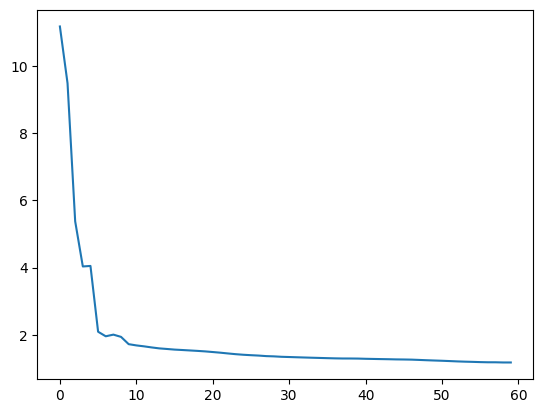

Fit on CLAS data


In [14]:
plt.figure()
plt.plot(f.history)
plt.show()
th.name = "Fit on CLAS data"
print(th.name)

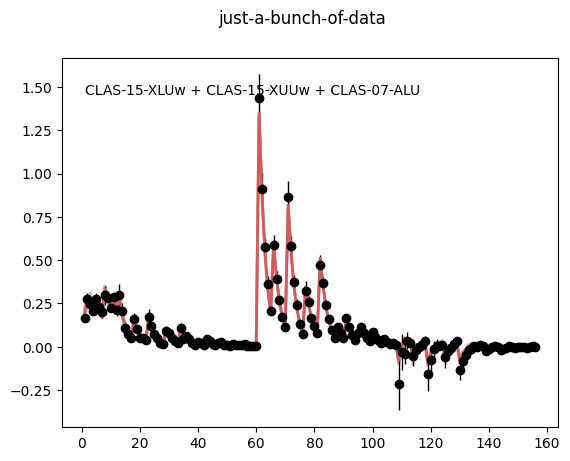

In [15]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

In [17]:
th.chisq(g.dset[8] + g.dset[101] + g.dset[102])

(np.float64(44.97659861761251), 156, np.float64(1.0))

### CFFs plots in the no DR case

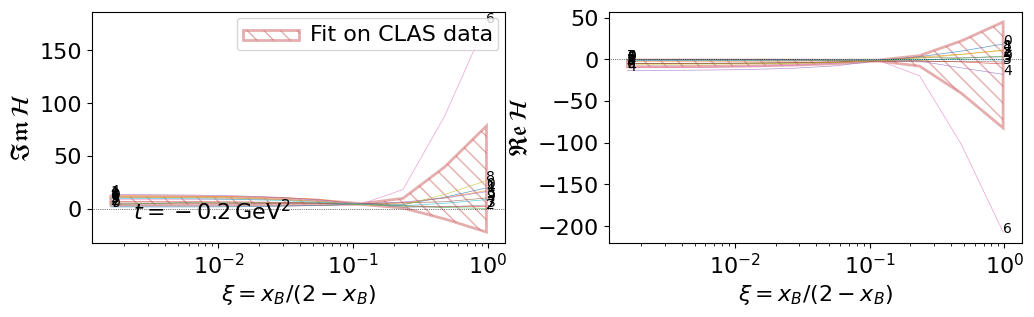

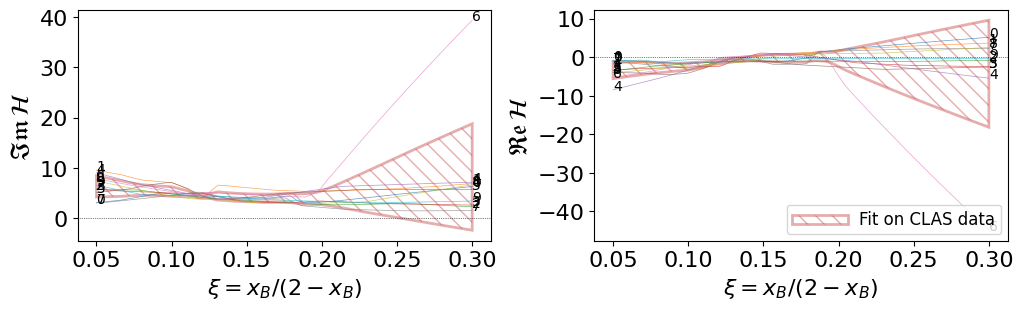

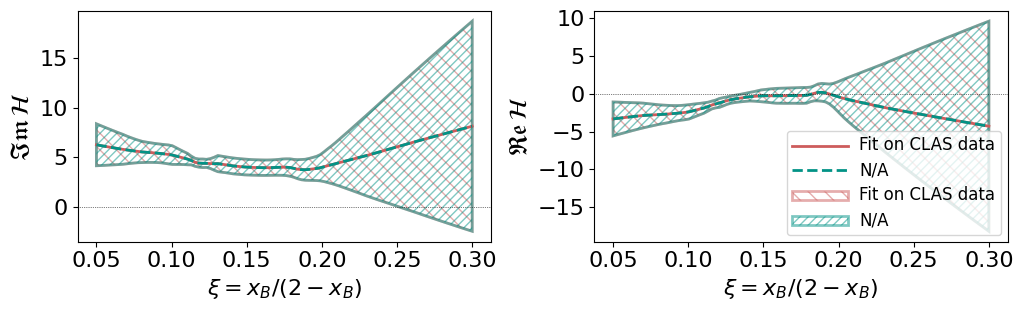

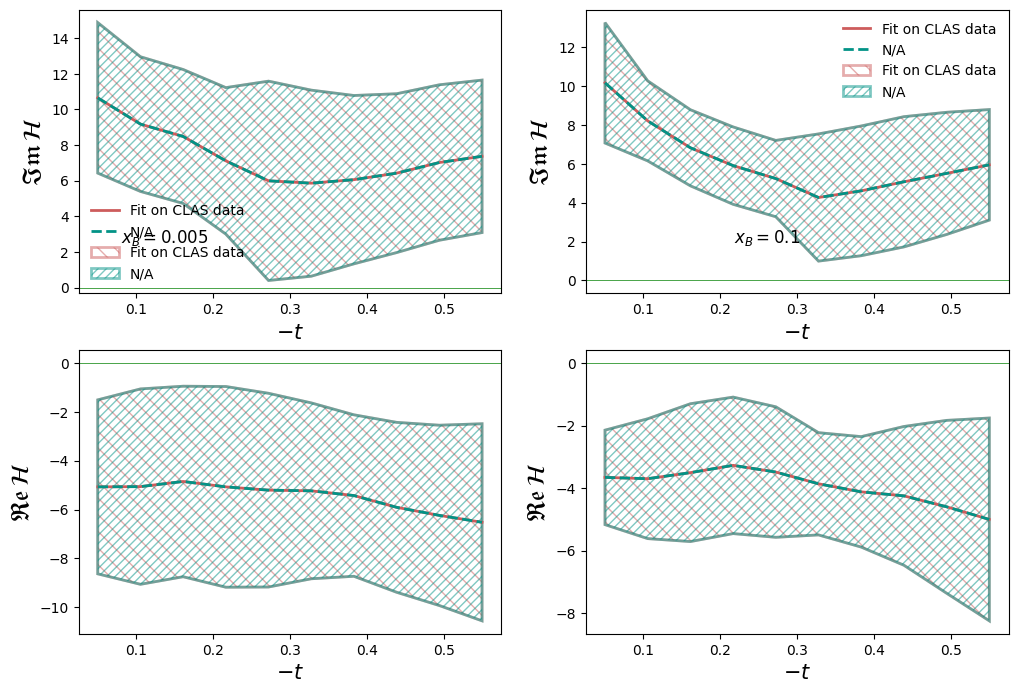

In [16]:
#fig = gplot.CFF3(cffs=['ImH', 'ReH'],  bands=[th], tval=-0.2)
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
#fig.savefig('NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

## Custom NN

In [26]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 7)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(7, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(7, 1)  # 7 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [27]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [28]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156
None


In [ ]:
g.describe_data(fitpoints)

In [29]:
fitpoints_1 =  g.dset[8] + g.dset[101] + g.dset[102] #+g.dset[97] + g.dset[99] +
g.describe_data(fitpoints_1)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 156


In [30]:
f = g.fitter.NeuralFitter(fitpoints_1, th2, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()
torch.save(th.nets, 'Test_dataset7_nets.tar')

/w/hallb-scshelf2102/clas12/pierre/GFF_Neural_Network/gepard/src/gepard/model.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch  10: train error = 2.1438 test error = 2.5111 -
Epoch  20: train error = 1.4720 test error = 1.8898 -
Epoch  30: train error = 1.4076 test error = 1.9694 +
Epoch  40: train error = 1.3861 test error = 1.9687 +
Epoch  50: train error = 1.3649 test error = 2.0013 +
Epoch  60: train error = 1.3576 test error = 2.0027 +test_err = 1.88978395775175 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.88978395775175

Epoch  10: train error = 3.6629 test error = 1.3814 -
Epoch  20: train error = 1.4380 test error = 1.6452 +
Epoch  30: train error = 1.3455 test error = 1.7588 +
Epoch  40: train error = 1.3292 test error = 1.7613 +
Epoch  50: train error = 1.3207 test error = 1.7616 +
Epoch  60: train error = 1.2796 test error = 1.7812 +
No improvement for 5 batches. Stopping early.
test_err = 1.3813612252251481 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.3813612252251481

Epoch  10: train error = 1.1614 test error = 1.7

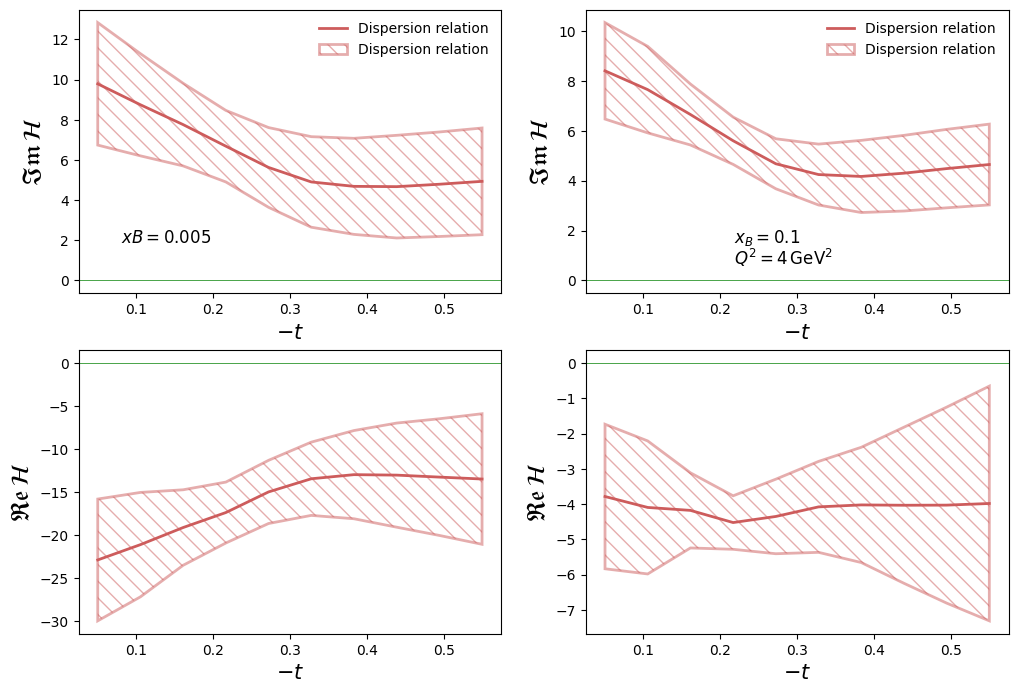

In [31]:
th2.name = "Dispersion relation"
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=th2, bands=[th2])

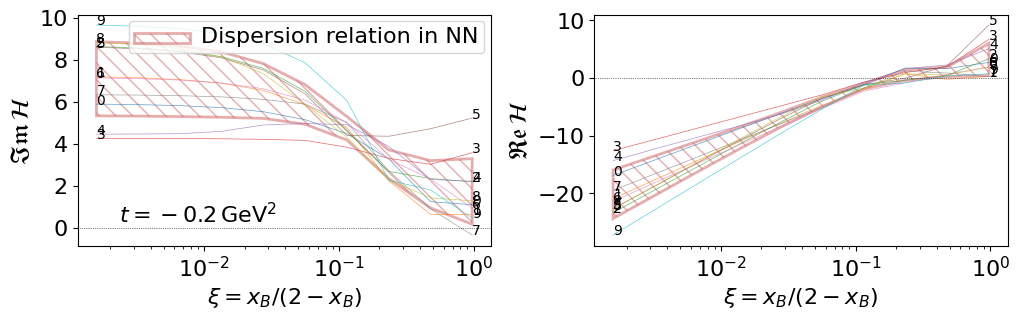

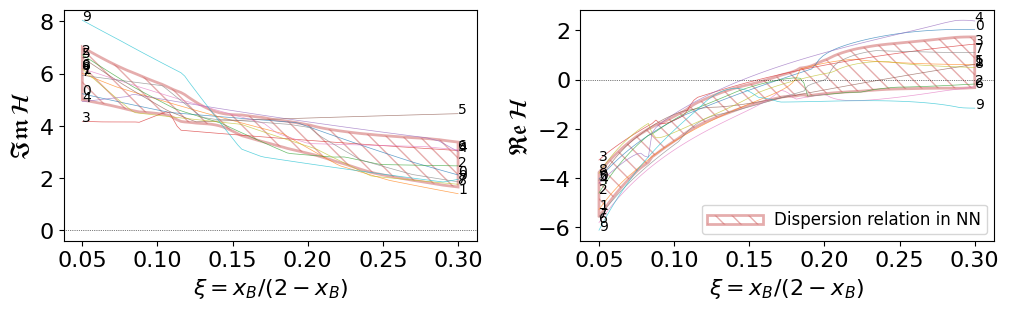

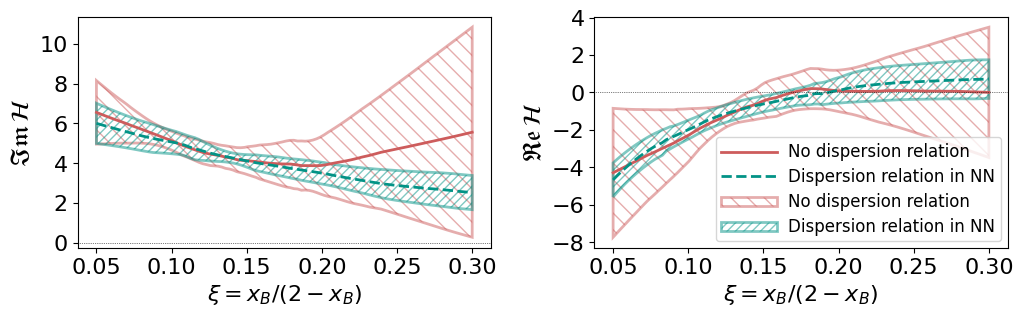

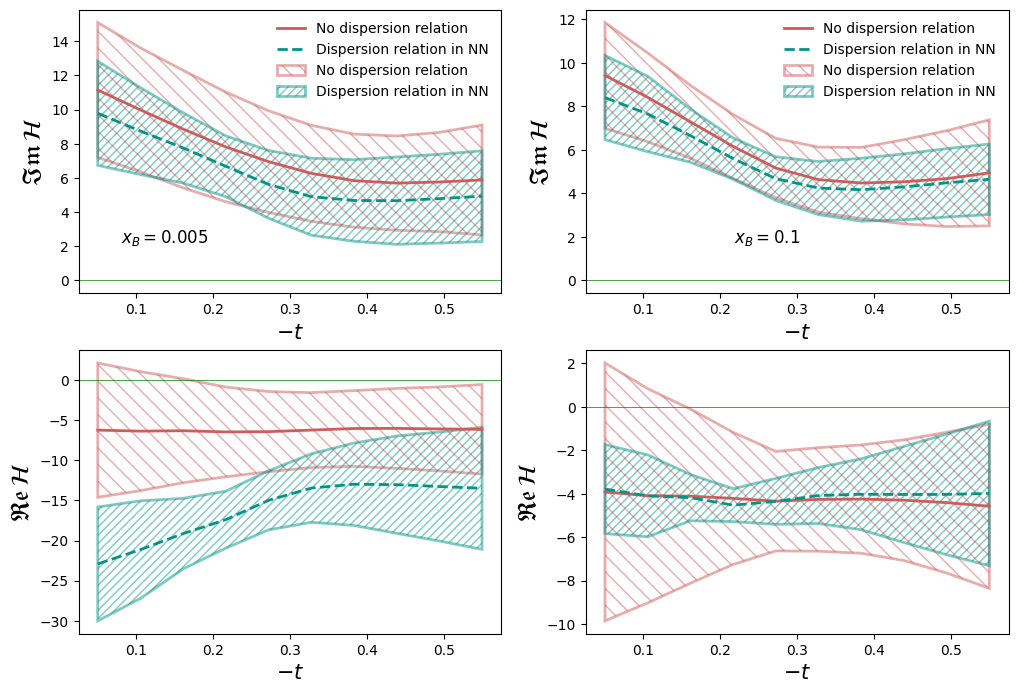

In [73]:
th.name = "No dispersion relation"
th2.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

## Test with 4 CFFs

In [103]:
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 7)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(7, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 7)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(7, 7)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(7, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [116]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [117]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [118]:
f = g.fitter.NeuralFitter(fitpoints_1, th3, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()


Epoch  10: train error = 1.5530 test error = 1.6207 -
Epoch  20: train error = 1.2582 test error = 1.7623 +
Epoch  30: train error = 1.1894 test error = 1.7423 +
Epoch  40: train error = 1.1615 test error = 1.8281 +
Epoch  50: train error = 1.1414 test error = 1.8490 +
Epoch  60: train error = 1.1243 test error = 1.8700 +
No improvement for 5 batches. Stopping early.
test_err = 1.620749622318969 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.620749622318969

Epoch  10: train error = 2.5694 test error = 1.8783 -
Epoch  20: train error = 1.3023 test error = 1.4375 -
Epoch  30: train error = 1.2597 test error = 1.4312 -
Epoch  40: train error = 1.2287 test error = 1.4960 +
Epoch  50: train error = 1.2091 test error = 1.4879 +
Epoch  60: train error = 1.1938 test error = 1.5298 +test_err = 1.4312186291756392 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.4312186291756392

Epoch  10: train error = 1.2662 test error = 1

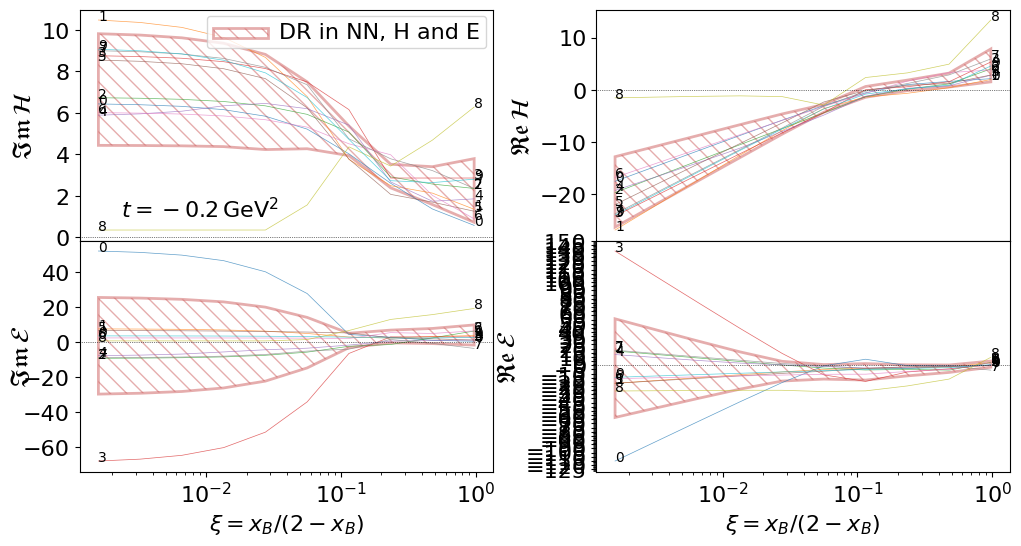

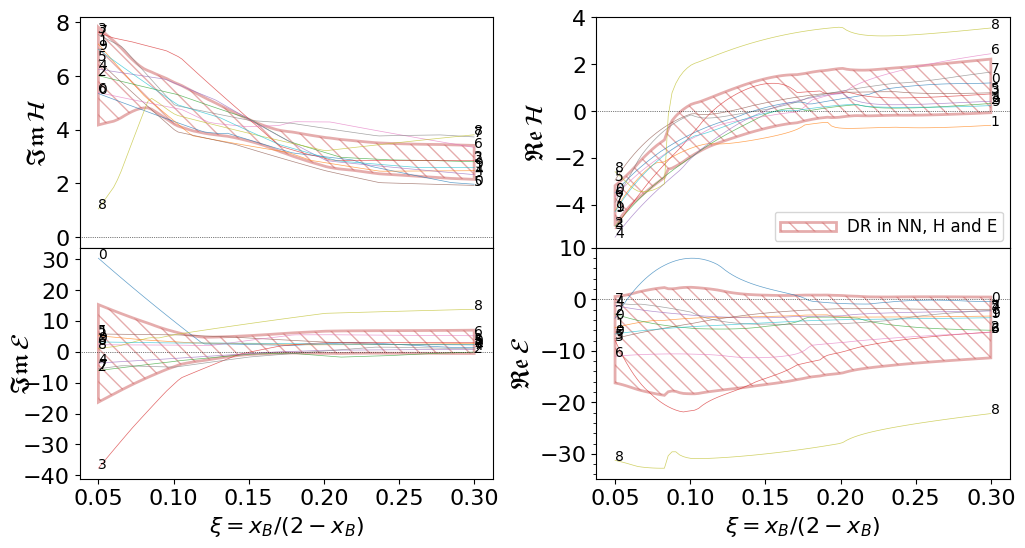

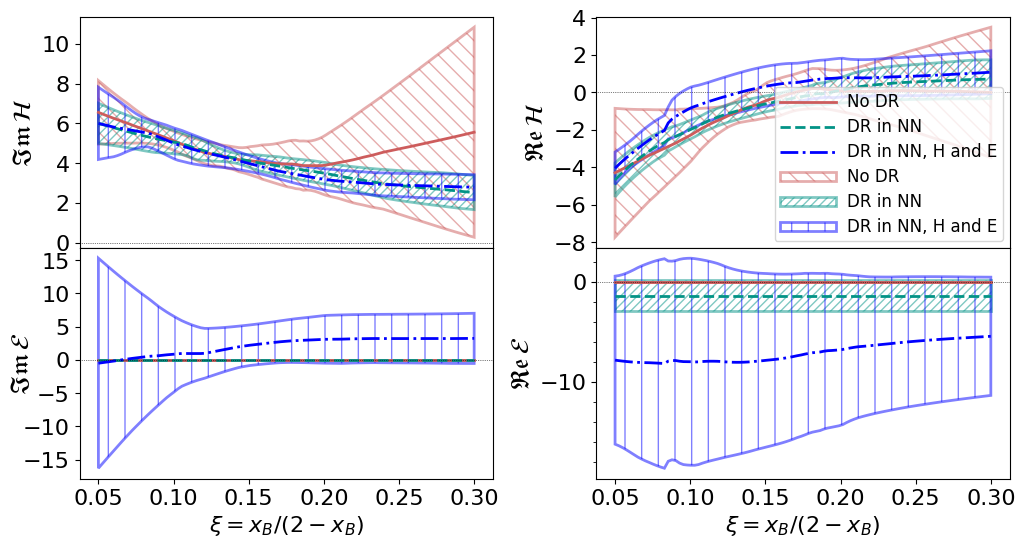

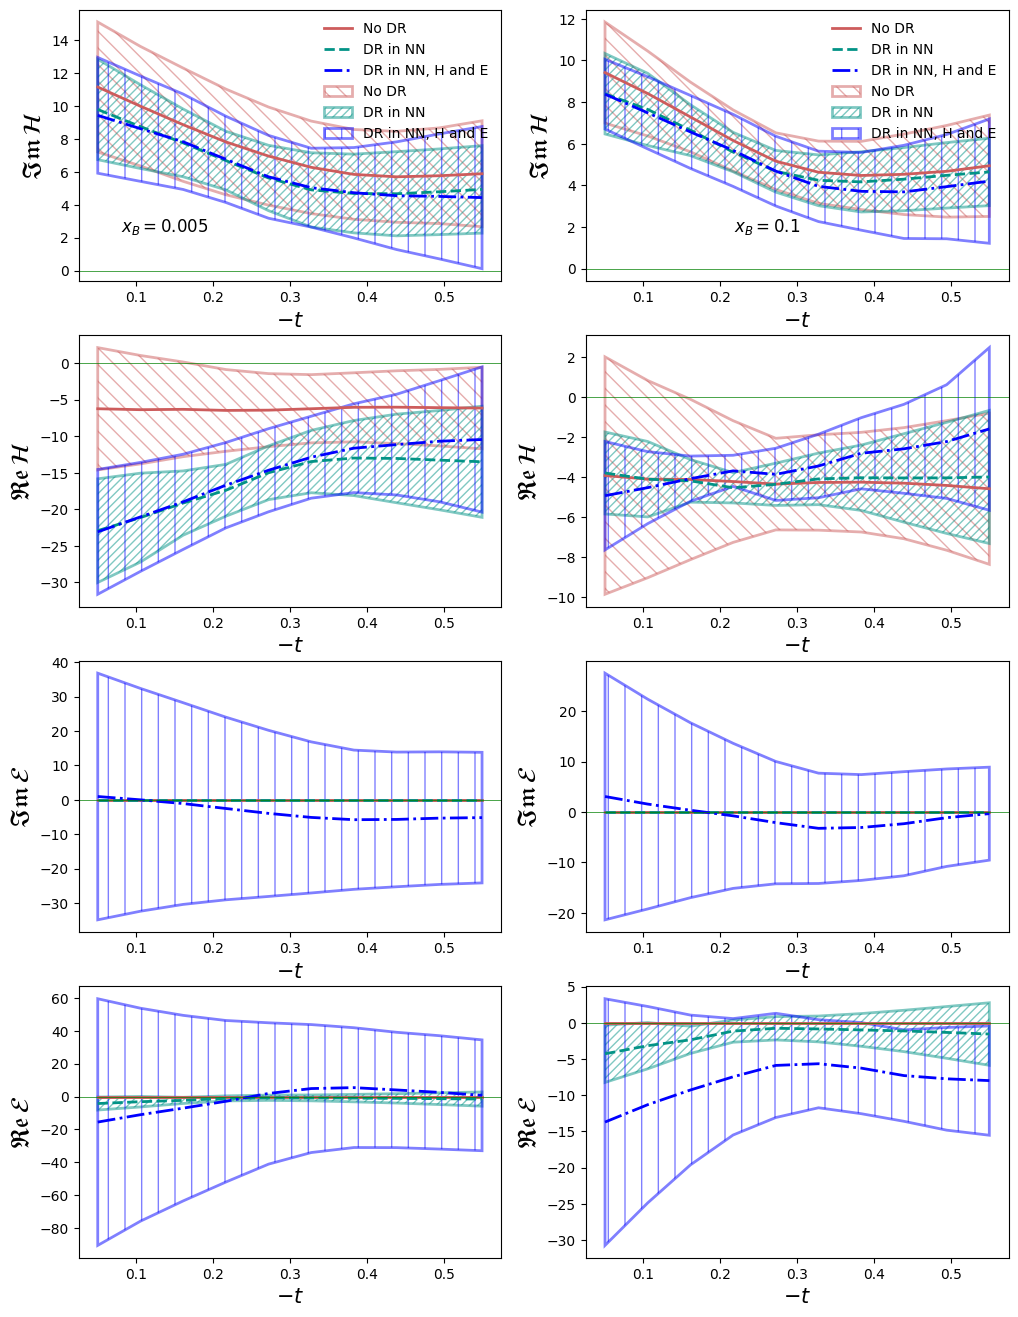

In [121]:
th.name = "No DR"
th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])